In [1]:
import pySRProxy

In [2]:
rdr = pySRProxy.StandardRecordFileReader("cafmaker/cafTree",
        ["/root/scratch/DUNE/FDInputs2024/VDProd/fardet-vd_mc_list-merge_physics_cafmaker_dunevd10kt_1x8x6_3view_30deg_runreco-nuenergy_geov3_root-tuple_merged_skip000000_lim000060_final_20241024T024241.root",])


Warning in <TClass::Init>: no dictionary for class genie::NtpMCEventRecord is available
Warning in <TClass::Init>: no dictionary for class genie::NtpMCRecordI is available
Warning in <TClass::Init>: no dictionary for class genie::NtpMCRecHeader is available
Warning in <TClass::Init>: no dictionary for class genie::EventRecord is available
Warning in <TClass::Init>: no dictionary for class genie::GHepRecord is available
Warning in <TClass::Init>: no dictionary for class genie::Interaction is available
Warning in <TClass::Init>: no dictionary for class genie::InitialState is available
Warning in <TClass::Init>: no dictionary for class genie::Target is available
Warning in <TClass::Init>: no dictionary for class genie::ProcessInfo is available
Warning in <TClass::Init>: no dictionary for class genie::Kinematics is available
Warning in <TClass::Init>: no dictionary for class pair<genie::EKineVar,double> is available
Warning in <TClass::Init>: no dictionary for class genie::XclsTag is avail

In [3]:
a = rdr.entry(0)
print("pandora:",[ x for x in dir(a.common.ixn.pandora[0]) if x[0] != "_"])
print("pandora.Enu:",[ x for x in dir(a.common.ixn.pandora[0].Enu) if x[0] != "_"])
print("pandora.vtx:",[ x for x in dir(a.common.ixn.pandora[0].vtx) if x[0] != "_"])
print("pandora.nuhyp:",[ x for x in dir(a.common.ixn.pandora[0].nuhyp) if x[0] != "_"])
print("pandora.nuhyp.cvn:", [ x for x in dir(a.common.ixn.pandora[0].nuhyp.cvn) if x[0] != "_"])


print(a.common.ixn.pandora[0].truth.at(0))

pandora: ['Ancestor', 'Enu', 'dir', 'id', 'nuhyp', 'part', 'preselected', 'truth', 'truthOverlap', 'vtx']
pandora.Enu: ['Ancestor', 'calo', 'e_calo', 'e_had', 'lep_calo', 'mu_had', 'mu_mcs', 'mu_mcs_llhd', 'mu_range', 'regcnn']
pandora.vtx: ['Ancestor', 'x', 'y', 'z']
pandora.nuhyp: ['Ancestor', 'cvn']
pandora.nuhyp.cvn: ['Ancestor', 'chgpi0', 'chgpi1', 'chgpi2', 'chgpiN', 'isnubar', 'nc', 'neutron0', 'neutron1', 'neutron2', 'neutronN', 'nue', 'numu', 'nutau', 'pizero0', 'pizero1', 'pizero2', 'pizeroN', 'protons0', 'protons1', 'protons2', 'protonsN']
0




# NuFast

In [6]:
import numpy as np

# Some constants
eVsqkm_to_GeV_over4 = 1e-9 / 1.97327e-7 * 1e3 / 4
YerhoE2a = 1.52588e-4

# Probability_Matter_LBL calculates all nine oscillation probabilities including
# the matter effect in an optimized, fast, and efficient way. The precision can
# be controlled with N_Newton. For many applications N_Newton=0 may be enough,
# but many years of DUNE or HK-LBL may require N_Newton=1. This code may be
# suitable for atmospheric neutrinos. The code is standalone with the Parameters
# module for several constants.
#
# Inputs:
#   mixing angles (usual parameterization)
#   phase (usual parameterization) make Dmsq31 positive/negative for the NO/IO
#   Delta msq's (eV^2)
#   L (km)
#   E (GeV) positive for neutrinos, negative for antineutrinos
#   rho (g/cc)
#   Ye: electron fraction, typically around 0.5
#   N_Newton: number of Newton's method iterations to do. should be zero, one, two (or higher)
# Outputs:
#   probs_returned is all nine oscillation probabilities: e.g. probs_returned[1][0] is mu->e
def Probability_Matter_LBL(s12sq, s13sq, s23sq, delta, Dmsq21, Dmsq31, L, E, rho, Ye, N_Newton):
	# --------------------------------------------------------------------- #
	# First calculate useful simple functions of the oscillation parameters #
	# --------------------------------------------------------------------- #
	c13sq = 1 - s13sq

	# Ueisq's
	Ue2sq = c13sq * s12sq
	Ue3sq = s13sq

	# Umisq's, Utisq's and Jvac	 
	Um3sq = c13sq * s23sq
	# Um2sq and Ut2sq are used here as temporary variables, will be properly defined later	 
	Ut2sq = s13sq * s12sq * s23sq
	Um2sq = (1 - s12sq) * (1 - s23sq)

	Jrr = np.sqrt(Um2sq * Ut2sq)
	sind = np.sin(delta)
	cosd = np.cos(delta)

	Um2sq = Um2sq + Ut2sq - 2 * Jrr * cosd
	Jmatter = 8 * Jrr * c13sq * sind
	Amatter = Ye * rho * E * YerhoE2a
	Dmsqee = Dmsq31 - s12sq * Dmsq21

	# calculate A, B, C, See, Tee, and part of Tmm
	A = Dmsq21 + Dmsq31 # temporary variable
	See = A - Dmsq21 * Ue2sq - Dmsq31 * Ue3sq
	Tmm = Dmsq21 * Dmsq31 # using Tmm as a temporary variable	  
	Tee = Tmm * (1 - Ue3sq - Ue2sq)
	C = Amatter * Tee
	A = A + Amatter

	# ---------------------------------- #
	# Get lambda3 from lambda+ of MP/DMP #
	# ---------------------------------- #
	xmat = Amatter / Dmsqee
	tmp = 1 - xmat
	lambda3 = Dmsq31 + 0.5 * Dmsqee * (xmat - 1 + np.sqrt(tmp * tmp + 4 * s13sq * xmat))

	# ---------------------------------------------------------------------------- #
	# Newton iterations to improve lambda3 arbitrarily, if needed, (B needed here) #
	# ---------------------------------------------------------------------------- #
	B = Tmm + Amatter * See # B is only needed for N_Newton >= 1
	for i in range(N_Newton):
		lambda3 = (lambda3 * lambda3 * (lambda3 + lambda3 - A) + C) / (lambda3 * (2 * (lambda3 - A) + lambda3) + B) # this strange form prefers additions to multiplications

	# ------------------- #
	# Get  Delta lambda's #
	# ------------------- #
	tmp = A - lambda3
	Dlambda21 = np.sqrt(tmp * tmp - 4 * C / lambda3)
	lambda2 = 0.5 * (A - lambda3 + Dlambda21)
	Dlambda32 = lambda3 - lambda2
	Dlambda31 = Dlambda32 + Dlambda21

	# ----------------------- #
	# Use Rosetta for Veisq's #
	# ----------------------- #
	# denominators	  
	PiDlambdaInv = 1 / (Dlambda31 * Dlambda32 * Dlambda21)
	Xp3 = PiDlambdaInv * Dlambda21
	Xp2 = -PiDlambdaInv * Dlambda31

	# numerators
	Ue3sq = (lambda3 * (lambda3 - See) + Tee) * Xp3
	Ue2sq = (lambda2 * (lambda2 - See) + Tee) * Xp2

	Smm = A - Dmsq21 * Um2sq - Dmsq31 * Um3sq
	Tmm = Tmm * (1 - Um3sq - Um2sq) + Amatter * (See + Smm - A)

	Um3sq = (lambda3 * (lambda3 - Smm) + Tmm) * Xp3
	Um2sq = (lambda2 * (lambda2 - Smm) + Tmm) * Xp2

	# ------------- #
	# Use NHS for J #
	# ------------- #
	Jmatter = Jmatter * Dmsq21 * Dmsq31 * (Dmsq31 - Dmsq21) * PiDlambdaInv

	# ----------------------- #
	# Get all elements of Usq #
	# ----------------------- #
	Ue1sq = 1 - Ue3sq - Ue2sq
	Um1sq = 1 - Um3sq - Um2sq

	Ut3sq = 1 - Um3sq - Ue3sq
	Ut2sq = 1 - Um2sq - Ue2sq
	Ut1sq = 1 - Um1sq - Ue1sq

	# ----------------------- #
	# Get the kinematic terms #
	# ----------------------- #
	Lover4E = eVsqkm_to_GeV_over4 * L / E

	D21 = Dlambda21 * Lover4E
	D32 = Dlambda32 * Lover4E
	  
	sinD21 = np.sin(D21)
	sinD31 = np.sin(D32 + D21)
	sinD32 = np.sin(D32)

	triple_sin = sinD21 * sinD31 * sinD32

	sinsqD21_2 = 2 * sinD21 * sinD21
	sinsqD31_2 = 2 * sinD31 * sinD31
	sinsqD32_2 = 2 * sinD32 * sinD32

	# ------------------------------------------------------------------- #
	# Calculate the three necessary probabilities, separating CPC and CPV #
	# ------------------------------------------------------------------- #
	Pme_CPC = (Ut3sq - Um2sq * Ue1sq - Um1sq * Ue2sq) * sinsqD21_2 \
				+ (Ut2sq - Um3sq * Ue1sq - Um1sq * Ue3sq) * sinsqD31_2 \
				+ (Ut1sq - Um3sq * Ue2sq - Um2sq * Ue3sq) * sinsqD32_2
	Pme_CPV = -Jmatter * triple_sin

	Pmm = 1 - 2 * (Um2sq * Um1sq * sinsqD21_2 \
				 + Um3sq * Um1sq * sinsqD31_2 \
				 + Um3sq * Um2sq * sinsqD32_2)

	Pee = 1 - 2 * (Ue2sq * Ue1sq * sinsqD21_2 \
				 + Ue3sq * Ue1sq * sinsqD31_2 \
				 + Ue3sq * Ue2sq * sinsqD32_2)

	# ---------------------------- #
	# Assign all the probabilities #
	# ---------------------------- #
	probs_returned = np.empty((3, 3))
	probs_returned[0][0] = Pee												# Pee
	probs_returned[0][1] = Pme_CPC - Pme_CPV								# Pem
	probs_returned[0][2] = 1 - Pee - probs_returned[0][1]  					# Pet

	probs_returned[1][0] = Pme_CPC + Pme_CPV								# Pme
	probs_returned[1][1] = Pmm												# Pmm
	probs_returned[1][2] = 1 - probs_returned[1][0] - Pmm					# Pmt

	probs_returned[2][0] = 1 - Pee - probs_returned[1][0]					# Pte
	probs_returned[2][1] = 1 - probs_returned[0][1] - Pmm					# Ptm
	probs_returned[2][2] = 1 - probs_returned[0][2] - probs_returned[1][2]	# Ptt

	return probs_returned

def Probability_Vacuum_LBL(s12sq, s13sq, s23sq, delta, Dmsq21, Dmsq31, L, E):
	# --------------------------------------------------------------------- #
	# First calculate useful simple functions of the oscillation parameters #
	# --------------------------------------------------------------------- #
	c13sq = 1 - s13sq

	# Ueisq's
	Ue3sq = s13sq
	Ue2sq = c13sq * s12sq

	# Umisq's, Utisq's and Jvac	 
	Um3sq = c13sq * s23sq
	# Um2sq and Ut2sq are used here as temporary variables, will be properly defined later	 
	Ut2sq = s13sq * s12sq * s23sq
	Um2sq = (1 - s12sq) * (1 - s23sq)
	  
	Jrr = np.sqrt(Um2sq * Ut2sq)
	sind = np.sin(delta)
	cosd = np.cos(delta)
	Um2sq = Um2sq + Ut2sq - 2 * Jrr * cosd
	Jvac = 8 * Jrr * c13sq * sind
	
	# ----------------------- #
	# Get all elements of Usq #
	# ----------------------- #
	Ue1sq = 1 - Ue3sq - Ue2sq
	Um1sq = 1 - Um3sq - Um2sq

	Ut3sq = 1 - Um3sq - Ue3sq
	Ut2sq = 1 - Um2sq - Ue2sq
	Ut1sq = 1 - Um1sq - Ue1sq

	# ----------------------- #
	# Get the kinematic terms #
	# ----------------------- #
	Lover4E = eVsqkm_to_GeV_over4 * L / E

	D21 = Dmsq21 * Lover4E
	D31 = Dmsq31 * Lover4E
	  
	sinD21 = np.sin(D21)
	sinD31 = np.sin(D31)
	sinD32 = np.sin(D31-D21)

	triple_sin = sinD21 * sinD31 * sinD32

	sinsqD21_2 = 2 * sinD21 * sinD21
	sinsqD31_2 = 2 * sinD31 * sinD31
	sinsqD32_2 = 2 * sinD32 * sinD32

	# ------------------------------------------------------------------- #
	# Calculate the three necessary probabilities, separating CPC and CPV #
	# ------------------------------------------------------------------- #
	Pme_CPC = (Ut3sq - Um2sq * Ue1sq - Um1sq * Ue2sq) * sinsqD21_2 \
			+ (Ut2sq - Um3sq * Ue1sq - Um1sq * Ue3sq) * sinsqD31_2 \
			+ (Ut1sq - Um3sq * Ue2sq - Um2sq * Ue3sq) * sinsqD32_2
	
	Pme_CPV = -Jvac * triple_sin

	Pmm = 1 - 2 * (Um2sq * Um1sq * sinsqD21_2 \
				 + Um3sq * Um1sq * sinsqD31_2 \
				 + Um3sq * Um2sq * sinsqD32_2)

	Pee = 1 - 2 * (Ue2sq * Ue1sq * sinsqD21_2 \
				 + Ue3sq * Ue1sq * sinsqD31_2 \
				 + Ue3sq * Ue2sq * sinsqD32_2)

	# ---------------------------- #
	# Assign all the probabilities #
	# ---------------------------- #
	probs_returned = np.empty((3, 3))
	probs_returned[0][0] = Pee												# Pee
	probs_returned[0][1] = Pme_CPC - Pme_CPV								# Pem
	probs_returned[0][2] = 1 - Pee - probs_returned[0][1]  					# Pet

	probs_returned[1][0] = Pme_CPC + Pme_CPV								# Pme
	probs_returned[1][1] = Pmm												# Pmm
	probs_returned[1][2] = 1 - probs_returned[1][0] - Pmm					# Pmt

	probs_returned[2][0] = 1 - Pee - probs_returned[1][0]					# Pte
	probs_returned[2][1] = 1 - probs_returned[0][1] - Pmm					# Ptm
	probs_returned[2][2] = 1 - probs_returned[0][2] - probs_returned[1][2]	# Ptt

	return probs_returned

if __name__ == "__main__":
	# ------------------------------- #
	# Set the experimental parameters #
	# ------------------------------- #
	L = 1300 # km
	E = 2.5 # GeV
	rho = 3 # g/cc
	Ye = 0.5

	# --------------------------------------------------------------------- #
	# Set the number of Newton-Raphson iterations which sets the precision. #
	# 0 is close to the single precision limit and is better than DUNE/HK   #
	# in the high statistics regime. Increasing N_Newton to 1,2,... rapidly #
	# improves the precision at a modest computational cost                 #
	# --------------------------------------------------------------------- #
	N_Newton = 0

	# ------------------------------------- #
	# Set the vacuum oscillation parameters #
	# ------------------------------------- #
	s12sq = 0.31
	s13sq = 0.02
	s23sq = 0.55
	delta = 0.7 * np.pi
	Dmsq21 = 7.5e-5 # eV^2
	Dmsq31 = 2.5e-3 # eV^2

	# ------------------------------------------ #
	# Calculate all 9 oscillations probabilities #
	# ------------------------------------------ #
	probs_returned = Probability_Matter_LBL(s12sq, s13sq, s23sq, delta, Dmsq21, Dmsq31, L, E, rho, Ye, N_Newton)

	# --------------------------- #
	# Print out the probabilities #
	# --------------------------- #
	print("L =", L, "E =", E, "rho =", rho)
	print("Probabilities:")
	print("alpha beta P(nu_alpha -> nu_beta)")
	for alpha in range(3):
		for beta in range(3):
			print(alpha, beta, probs_returned[alpha][beta])

L = 1300 E = 2.5 rho = 3
Probabilities:
alpha beta P(nu_alpha -> nu_beta)
0 0 0.8805901698822846
0 1 0.07803625954236093
0 2 0.04137357057535451
1 0 0.0537610206524951
1 1 0.005903280202548489
1 2 0.9403356991449564
2 0 0.06564880946522034
2 1 0.9160604602550906
2 2 0.018290730279689082


In [7]:
def prob_DUNE(enu_GeV, frompdg, topdg):
    # ------------------------------- #
	# Set the experimental parameters #
	# ------------------------------- #
	L = 1300 # km
	rho = 3 # g/cc
	Ye = 0.5

	# --------------------------------------------------------------------- #
	# Set the number of Newton-Raphson iterations which sets the precision. #
	# 0 is close to the single precision limit and is better than DUNE/HK   #
	# in the high statistics regime. Increasing N_Newton to 1,2,... rapidly #
	# improves the precision at a modest computational cost                 #
	# --------------------------------------------------------------------- #
	N_Newton = 0

	# ------------------------------------- #
	# Set the vacuum oscillation parameters #
	# ------------------------------------- #
	s12sq = 0.31
	s13sq = 0.02
	s23sq = 0.55
	delta = 0.7 * np.pi
	Dmsq21 = 7.5e-5 # eV^2
	Dmsq31 = 2.5e-3 # eV^2

	alpha = (abs(frompdg) - 12)//2
	beta = (abs(topdg) - 12)//2

	if frompdg < 0:
		enu_GeV = -enu_GeV        
    
	return Probability_Matter_LBL(s12sq, s13sq, s23sq, delta, Dmsq21, Dmsq31, L, enu_GeV, rho, Ye, N_Newton)[alpha][beta]

prob_DUNE(2.3, 14, 14)


0.03468315089762941

# Building the analysis object

In [8]:
events = { "vtxx": [], "vtxy": [],"vtxz": [], "cvnnue": [], "cvnnumu": [], "cvnnc": [],
          "enu_calo": [], "enu_lep_calo": [], "enu_regcnn": [],
          "true_nupdg": [], "true_iscc": [], "true_enu_GeV": [], 
          "true_vtxx": [], "true_vtxy": [], "true_vtxz": [],
          "oscprob": [] }
for i,ent in enumerate(rdr):
    for inx in ent.common.ixn.pandora:
        events["vtxx"].append(inx.vtx.x)
        events["vtxy"].append(inx.vtx.y)
        events["vtxz"].append(inx.vtx.z)
        
        events["cvnnue"].append(inx.nuhyp.cvn.nue)
        events["cvnnumu"].append(inx.nuhyp.cvn.numu)
        events["cvnnc"].append(inx.nuhyp.cvn.nc)

        events["enu_calo"].append(inx.Enu.calo)
        events["enu_lep_calo"].append(inx.Enu.lep_calo)
        events["enu_regcnn"].append(inx.Enu.regcnn)
        
        #FD so we know there is only 1 int/spill, don't need fancy truth matching
        trueint = ent.mc.nu[0]

        events["true_nupdg"].append(trueint.pdg)
        events["true_iscc"].append(trueint.iscc)
        events["true_enu_GeV"].append(trueint.E)
        events["true_vtxx"].append(trueint.vtx.x)
        events["true_vtxy"].append(trueint.vtx.y)
        events["true_vtxz"].append(trueint.vtx.z)
        
        events["oscprob"].append(prob_DUNE(trueint.E, trueint.pdgorig, trueint.pdg) if trueint.iscc else 1)

In [9]:
import pandas as pd

df = pd.DataFrame(events)

In [10]:
df

,vtxx,vtxy,vtxz,cvnnue,cvnnumu,cvnnc,enu_calo,enu_lep_calo,enu_regcnn,true_nupdg,true_iscc,true_enu_GeV,true_vtxx,true_vtxy,true_vtxz,oscprob
0,266.329163,-238.183685,264.626617,0.001419,0.983378,0.013947,1.931360,3.593848,NaN,14,True,3.525392,266.027527,-238.412903,264.277435,0.178809
1,103.294914,661.857056,168.547195,0.003260,0.985256,0.010998,2.513457,3.918122,NaN,14,True,4.479316,103.064720,661.718750,168.293182,0.392434
2,-68.737213,593.285828,1.169922,0.005930,0.958681,0.010558,0.894460,3.895253,NaN,14,True,2.936577,-66.420662,590.642944,-13.778516,0.045253
3,-163.962616,-192.257309,147.996628,0.002540,0.978156,0.014386,2.121075,2.251435,NaN,14,True,3.782442,-163.943253,-192.579483,148.527847,0.240964
4,-62.427994,359.248505,45.753056,0.001389,0.004870,0.991805,0.699495,1.249212,NaN,14,False,1.750327,-64.946869,357.434601,36.398750,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545008,138.656479,-5.480026,376.897369,0.001579,0.005346,0.991328,0.761028,0.869076,NaN,14,False,3.306130,138.735352,-5.518766,376.617920,1.000000
545009,187.361328,651.855469,463.641846,0.002086,0.013236,0.977724,0.437696,0.437696,NaN,14,False,3.779285,186.516830,652.174500,463.574890,1.000000
545010,300.516815,139.685272,514.372070,0.007998,0.010229,0.979517,0.549049,1.126366,NaN,14,False,3.560216,300.432404,138.381775,514.202515,1.000000
545011,17.147131,-652.038757,337.798218,0.011013,0.915359,0.071029,1.626123,1.440065,NaN,14,True,4.324965,16.970161,-652.192017,337.960815,0.361624


In [9]:
df.to_parquet("FDInteractions.pq")

In [1]:
import pandas as pd

df = pd.read_parquet("FDInteractions.pq")

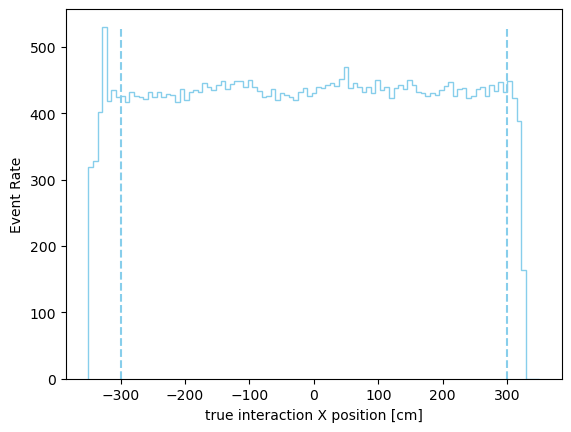

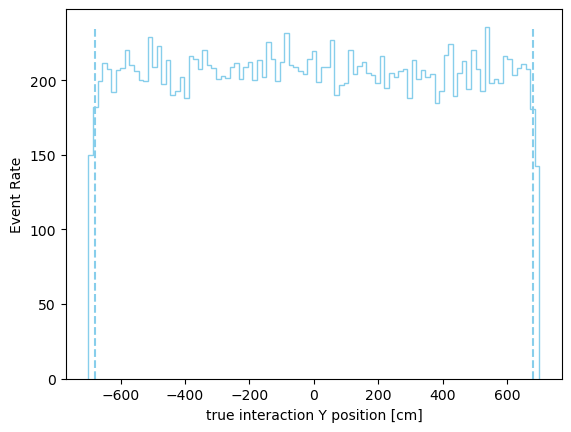

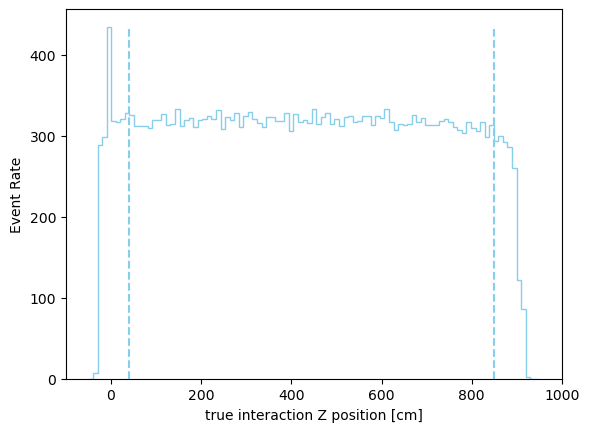

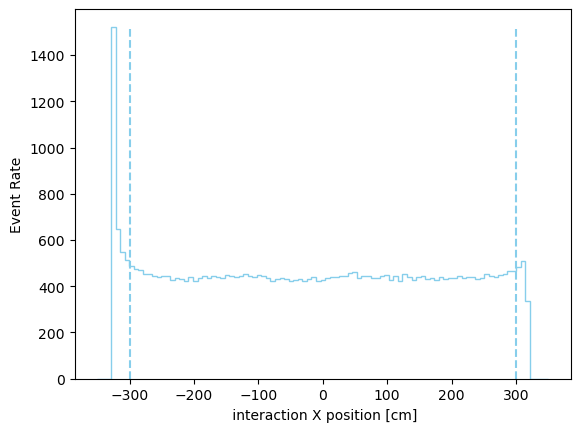

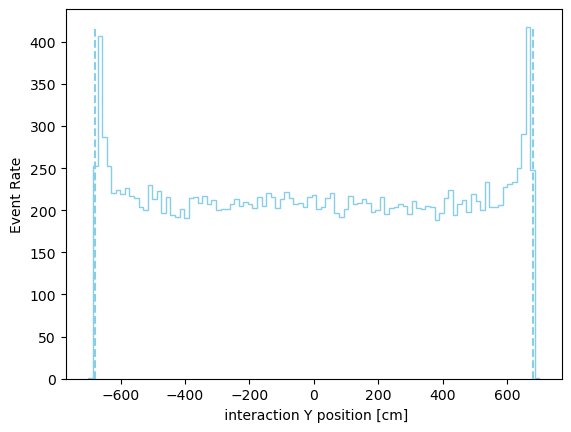

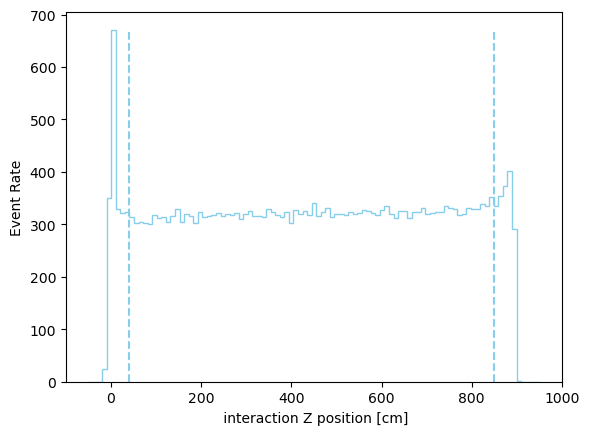

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def hist1d(data, bins, weights):
    bin_vals, bins = np.histogram(data, bins=bins, weights=weights)
    bws = (bins[1:] - bins[:-1])

    return (bin_vals/bws, bins)

def drawhist1d(data, bins, weights, cut_lines=None, **kwargs):

    counts, bins = hist1d(data, bins, weights)
    plt.gca().stairs(counts, bins, **kwargs)
    if cut_lines is not None:
        plt.gca().plot([cut_lines[0],cut_lines[0]],[0,max(counts)], **kwargs, linestyle="dashed")
        plt.gca().plot([cut_lines[1],cut_lines[1]],[0,max(counts)], **kwargs, linestyle="dashed")

#draw training FV from https://github.com/DUNE/dunereco/blob/ff92d1bc966c6e3cf7db1a434c8a723e74b0712c/dunereco/CVN/art/CVNZlibMaker_module.cc#L295
# isFid = (fabs(vtx.X())<300 && fabs(vtx.Y())<680 && vtx.Z()>40 && vtx.Z()<850); // vd
drawhist1d(df["true_vtxx"], np.linspace(-350,350,100), df["oscprob"], [-300,300], color="skyblue")
plt.xlabel("true interaction X position [cm]")
plt.ylabel("Event Rate")
plt.show()

drawhist1d(df["true_vtxy"], np.linspace(-700,700,100), df["oscprob"], [-680,680], color="skyblue")
plt.xlabel("true interaction Y position [cm]")
plt.ylabel("Event Rate")
plt.show()

drawhist1d(df["true_vtxz"], np.linspace(-50,950,100), df["oscprob"], [40,850], color="skyblue")
plt.xlabel("true interaction Z position [cm]")
plt.ylabel("Event Rate")
plt.show()

drawhist1d(df["vtxx"], np.linspace(-350,350,100), df["oscprob"], [-300,300], color="skyblue")
plt.xlabel(" interaction X position [cm]")
plt.ylabel("Event Rate")
plt.show()

drawhist1d(df["vtxy"], np.linspace(-700,700,100), df["oscprob"], [-680,680], color="skyblue")
plt.xlabel(" interaction Y position [cm]")
plt.ylabel("Event Rate")
plt.show()

drawhist1d(df["vtxz"], np.linspace(-50,950,100), df["oscprob"], [40,850], color="skyblue")
plt.xlabel(" interaction Z position [cm]")
plt.ylabel("Event Rate")
plt.show()

# Simple 1D Cut Optimization

We should start with the Fiducial Volume used to train the CVN. It may be further optimizable, it may not. The definition of that FV can be found [here](https://github.com/DUNE/dunereco/blob/ff92d1bc966c6e3cf7db1a434c8a723e74b0712c/dunereco/CVN/art/CVNZlibMaker_module.cc#L301C9-L301C93).

In [3]:
def applyVDFV(df):
    return df[(abs(df["vtxx"]) < 300) & (abs(df["vtxy"]) < 680) & (df["vtxz"] > 40) & (df["vtxz"] < 680)]

dffv = applyVDFV(df)

In [4]:
dffv

,vtxx,vtxy,vtxz,cvnnue,cvnnumu,cvnnc,enu_calo,enu_lep_calo,enu_regcnn,true_nupdg,true_iscc,true_enu_GeV,true_vtxx,true_vtxy,true_vtxz,oscprob
0,266.329163,-238.183685,264.626617,0.001419,0.983378,0.013947,1.931360,3.593848,NaN,14,True,3.525392,266.027527,-238.412903,264.277435,0.178809
1,103.294914,661.857056,168.547195,0.003260,0.985256,0.010998,2.513457,3.918122,NaN,14,True,4.479316,103.064720,661.718750,168.293182,0.392434
3,-163.962616,-192.257309,147.996628,0.002540,0.978156,0.014386,2.121075,2.251435,NaN,14,True,3.782442,-163.943253,-192.579483,148.527847,0.240964
4,-62.427994,359.248505,45.753056,0.001389,0.004870,0.991805,0.699495,1.249212,NaN,14,False,1.750327,-64.946869,357.434601,36.398750,1.000000
5,-57.286697,242.243973,91.968773,0.001857,0.990286,0.006713,1.382747,1.632006,NaN,14,True,2.904292,-57.141781,241.917923,91.971939,0.039486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545006,-75.869896,-10.463987,44.263458,0.001442,0.974448,0.018093,2.203084,2.634277,NaN,14,True,2.824683,-76.848473,-10.794485,41.947842,0.026667
545008,138.656479,-5.480026,376.897369,0.001579,0.005346,0.991328,0.761028,0.869076,NaN,14,False,3.306130,138.735352,-5.518766,376.617920,1.000000
545009,187.361328,651.855469,463.641846,0.002086,0.013236,0.977724,0.437696,0.437696,NaN,14,False,3.779285,186.516830,652.174500,463.574890,1.000000
545011,17.147131,-652.038757,337.798218,0.011013,0.915359,0.071029,1.626123,1.440065,NaN,14,True,4.324965,16.970161,-652.192017,337.960815,0.361624


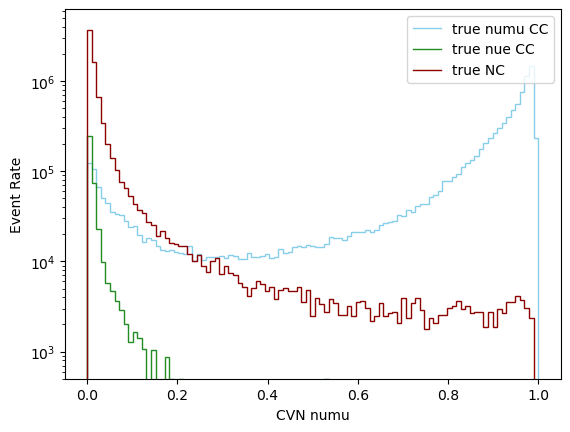

In [5]:
isnumu = abs(dffv["true_nupdg"]) == 14
isnue = abs(dffv["true_nupdg"]) == 12
iscc = dffv["true_iscc"]

drawhist1d(dffv[isnumu & iscc]["cvnnumu"], np.linspace(0,1,100), dffv[isnumu & iscc]["oscprob"], color="skyblue", label="true numu CC")
drawhist1d(dffv[isnue & iscc]["cvnnumu"], np.linspace(0,1,100), dffv[isnue & iscc]["oscprob"], color="forestgreen", label="true nue CC")
drawhist1d(dffv[~iscc]["cvnnumu"], np.linspace(0,1,100), dffv[~iscc]["oscprob"], color="darkred", label="true NC")

plt.xlabel("CVN numu")
plt.ylabel("Event Rate")
plt.legend()
plt.yscale('log')
plt.ylim(5E2)
plt.show()

## Optimization Metric

Could optimize for a range of outcomes, for this demo we will use the efficiency * purity of the selected signal (which is equivalent to signal to noise).

Efficiency is the number of objects you correctly select out of how many happened.

Purity is the number of objects that you correctly select out of how many you selected.

In [6]:
def eff(df, reco_cuts, true_cuts):
    num = sum(df[reco_cuts & true_cuts]["oscprob"])
    denom = sum(df[true_cuts]["oscprob"])
    return num / denom if denom > 0 else 0

def pur(df, reco_cuts, true_cuts):
    num = sum(df[reco_cuts & true_cuts]["oscprob"])
    denom = sum(df[reco_cuts]["oscprob"])
    return num / denom if denom > 0 else 0

In [7]:
def cvncutopt_lb(df, cutname, cut_range, reco_cuts, true_cuts):
    x = np.linspace(cut_range[0],cut_range[1],200)
    yeff = [ eff(df, reco_cuts & (df[cutname] > cutv), true_cuts) for cutv in x ]
    ypur = [ pur(df, reco_cuts & (df[cutname] > cutv), true_cuts) for cutv in x ]
    yeffpur = [ yeff[i]*ypur[i] for i in range(200) ]

    plt.plot(x,yeff,label="efficiency")
    plt.plot(x,ypur,label="purity")
    plt.plot(x,yeffpur,label="eff*pur")

    xmax = np.argmax(yeffpur) * 1.0/200.0
    plt.plot([xmax, xmax],[0,1], color="black", linestyle="dashed")
    plt.gca().annotate("", xytext=(xmax, 0.5), xy=(xmax+0.1, 0.5),
            arrowprops=dict(arrowstyle="->"))
    
    plt.xlabel(f"{cutname} cut value")
    plt.legend()

    return xmax, yeff[np.argmax(yeffpur)], ypur[np.argmax(yeffpur)]

def cvncutopt_ub(df, cutname, cut_range, reco_cuts, true_cuts):
    x = np.linspace(cut_range[0],cut_range[1],200)
    yeff = [ eff(df, reco_cuts & (df[cutname] < cutv), true_cuts) for cutv in x ]
    ypur = [ pur(df, reco_cuts & (df[cutname] < cutv), true_cuts) for cutv in x ]
    yeffpur = [ yeff[i]*ypur[i] for i in range(200) ]

    plt.plot(x,yeff,label="efficiency")
    plt.plot(x,ypur,label="purity")
    plt.plot(x,yeffpur,label="eff*pur")
    xmax = np.argmax(yeffpur) * 1.0/200.0
    plt.plot([xmax, xmax],[0,1], color="black", linestyle="dashed")
    plt.gca().annotate("", xytext=(xmax, 0.5), xy=(xmax-0.1, 0.5),
            arrowprops=dict(arrowstyle="->"))

    plt.xlabel(f"{cutname} cut value")
    plt.legend()

    return xmax, yeff[np.argmax(yeffpur)], ypur[np.argmax(yeffpur)]

Lets try and optimize the numu selection cuts

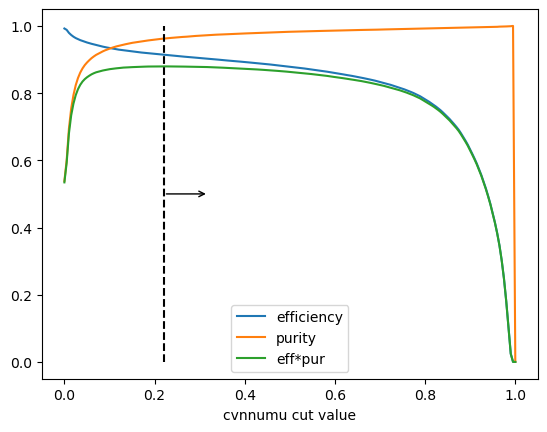

Optimum cut value: 0.22 @ 0.91 efficiency & 0.96 purity


In [8]:
cvnnumu_cut, opteff, optpur = cvncutopt_lb(dffv, "cvnnumu", [0,1], True, isnumu & iscc)
plt.show()
print(f"Optimum cut value: {cvnnumu_cut} @ {opteff:.2} efficiency & {optpur:.2} purity")

Eff*Pur is quite flat, so the exact choice isn't so important. Check if the other discriminators offer any additional power against this metric.

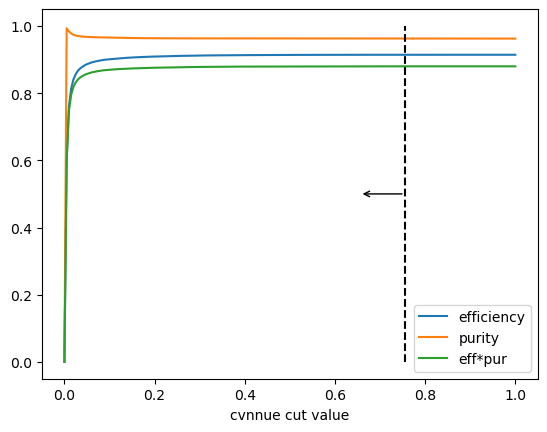

Optimum cut value: 0.755 @ 0.91 efficiency & 0.96 purity


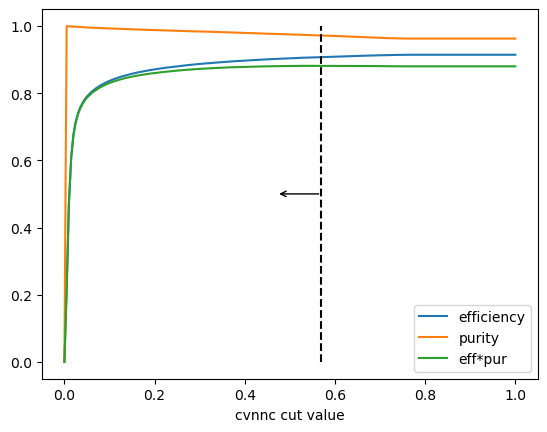

Optimum cut value: 0.57 @ 0.91 efficiency & 0.97 purity


In [9]:
cvnnue_cut, opteff, optpur = cvncutopt_ub(dffv, "cvnnue", [0,1], dffv["cvnnumu"] > 0.22,isnumu & iscc)
plt.show()
print(f"Optimum cut value: {cvnnue_cut} @ {opteff:.2} efficiency & {optpur:.2} purity")

cvnnc_cut, opteff, optpur = cvncutopt_ub(dffv, "cvnnc", [0,1], dffv["cvnnumu"] > 0.22,isnumu & iscc)
plt.show()
print(f"Optimum cut value: {cvnnc_cut} @ {opteff:.2} efficiency & {optpur:.2} purity")

Seems like there might be a marginal improvement in overall purity at `cvnnue < 0.76 & cvnnc < 0.57`. 

Let's check if these conclusions hold up if we optimize the cuts pairwise.

In [10]:
def opt_lbup(df, xcutname, xcut_range, ycutname, ycut_range, true_cuts, nbins):
    x = np.linspace(xcut_range[0],xcut_range[1],nbins)
    y = np.linspace(ycut_range[0],ycut_range[1],nbins)
    
    e = np.zeros((nbins-1,nbins-1))
    p = np.zeros((nbins-1,nbins-1))

    for i in range(nbins-1):
        for j in range(nbins-1):
            xthresh = (x[i] + x[i+1])/2.0
            ythresh = (y[j] + y[j+1])/2.0
            e[i,j] = eff(df, (df[xcutname] > xthresh) & (df[ycutname] < ythresh), true_cuts)
            p[i,j] = pur(df, (df[xcutname] > xthresh) & (df[ycutname] < ythresh), true_cuts)

    ep = e*p
    xymax = np.unravel_index(np.argmax(ep), ep.shape)
        
    pcm = plt.pcolormesh(x, y, ep.T)
    plt.gcf().colorbar(pcm, ax=plt.gca())

    xmax, ymax = (x[xymax[0]] + x[xymax[0]+1])/2.0, (y[xymax[1]] + y[xymax[1]+1])/2.0

    plt.plot([xmax,xmax],[0,1], color="black", linestyle="dashed")
    plt.gca().annotate("", xytext=(xmax, 0.5), xy=(xmax+0.1, 0.5),
            arrowprops=dict(arrowstyle="->"))

    plt.plot([0,1],[ymax,ymax], color="black", linestyle="dashed")
    plt.gca().annotate("", xytext=(0.5, ymax), xy=(0.5, ymax-0.1),
            arrowprops=dict(arrowstyle="->"))    
    return xmax, ymax, e[xymax[0],xymax[1]], p[xymax[0],xymax[1]]

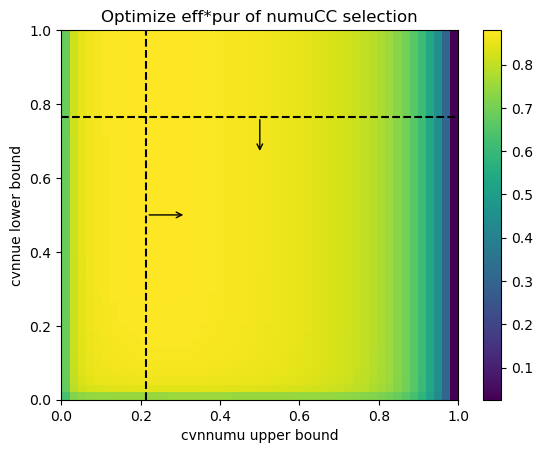

max at cvnnumu > 0.21, cvnnue < 0.77 @ 0.91 efficiency & 0.96 purity


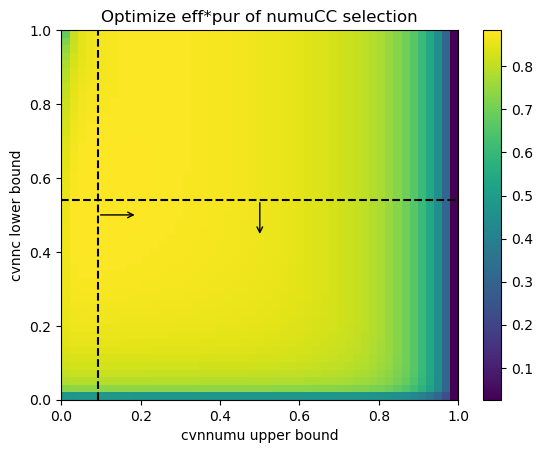

max at cvnnumu > 0.092, cvnnc < 0.54 @ 0.92 efficiency & 0.96 purity


In [16]:
xmaxv,ymaxv, opteff, optpur  = opt_lbup(dffv, "cvnnumu", [0,1], "cvnnue", [0,1], isnumu & iscc, 50)
plt.xlabel("cvnnumu upper bound")
plt.ylabel("cvnnue lower bound")
plt.title("Optimize eff*pur of numuCC selection")
plt.show()
print(f"max at cvnnumu > {xmaxv:.2}, cvnnue < {ymaxv:.2} @ {opteff:.2} efficiency & {optpur:.2} purity")

xmaxv,ymaxv, opteff, optpur  = opt_lbup(dffv, "cvnnumu", [0,1], "cvnnc", [0,1], isnumu & iscc, 50)
plt.xlabel("cvnnumu upper bound")
plt.ylabel("cvnnc lower bound")
plt.title("Optimize eff*pur of numuCC selection")
plt.show()
print(f"max at cvnnumu > {xmaxv:.2}, cvnnc < {ymaxv:.2} @ {opteff:.2} efficiency & {optpur:.2} purity")

Similar conclusions, given how flat the eff*pur is over a lot of the `cvnnumu` range, this isn't so surprising. We could optimize all three simultaneously, but for this demo we will leave it here.

Lets optimize the nue and nc cuts in the same way. Firstly, nueCC.

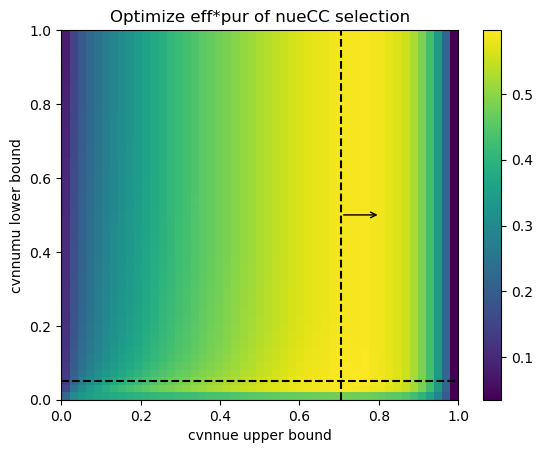

max at cvnnue > 0.7, cvnnumu < 0.051 @ 0.77 efficiency & 0.78 purity


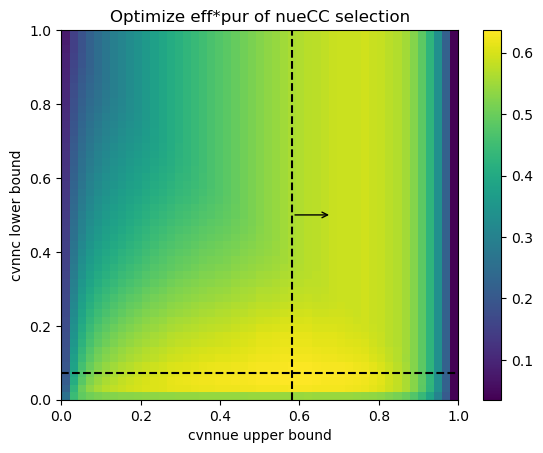

max at cvnnue > 0.58, cvnnc < 0.071 @ 0.77 efficiency & 0.83 purity


In [17]:
xmaxv,ymaxv, opteff, optpur = opt_lbup(dffv, "cvnnue", [0,1], "cvnnumu", [0,1], isnue & iscc, 50)
plt.xlabel("cvnnue upper bound")
plt.ylabel("cvnnumu lower bound")
plt.title("Optimize eff*pur of nueCC selection")
plt.show()
print(f"max at cvnnue > {xmaxv:.2}, cvnnumu < {ymaxv:.2} @ {opteff:.2} efficiency & {optpur:.2} purity")

xmaxv,ymaxv, opteff, optpur = opt_lbup(dffv, "cvnnue", [0,1], "cvnnc", [0,1], isnue & iscc, 50)
plt.xlabel("cvnnue upper bound")
plt.ylabel("cvnnc lower bound")
plt.title("Optimize eff*pur of nueCC selection")
plt.show()
print(f"max at cvnnue > {xmaxv:.2}, cvnnc < {ymaxv:.2} @ {opteff:.2} efficiency & {optpur:.2} purity")

It seems like a cut on `cvnnumu` has relatively minimal effect on the nueCC sample selection, however, unsurprisingly perhaps, the nc discriminator does impact a nue selection.

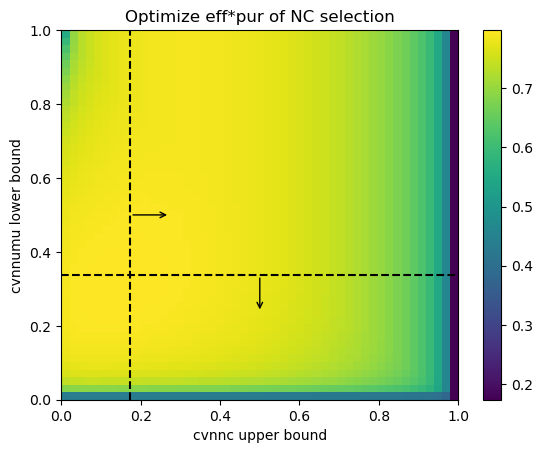

max at cvnnc > 0.17, cvnnumu < 0.34 @ 0.89 efficiency & 0.9 purity


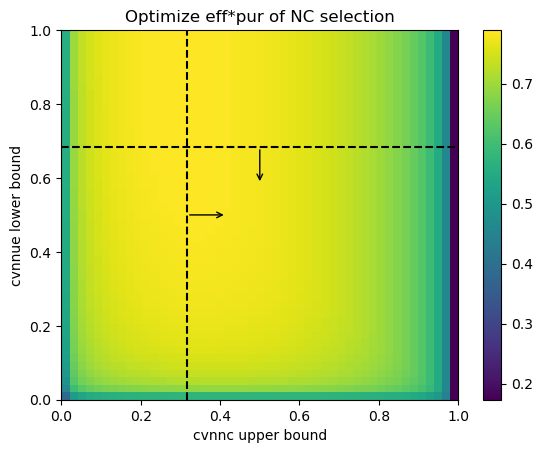

max at cvnnc > 0.32, cvnnue < 0.68 @ 0.89 efficiency & 0.89 purity


In [18]:
xmaxv,ymaxv, opteff, optpur = opt_lbup(dffv, "cvnnc", [0,1], "cvnnumu", [0,1], ~iscc, 50)
plt.xlabel("cvnnc upper bound")
plt.ylabel("cvnnumu lower bound")
plt.title("Optimize eff*pur of NC selection")
plt.show()
print(f"max at cvnnc > {xmaxv:.2}, cvnnumu < {ymaxv:.2} @ {opteff:.2} efficiency & {optpur:.2} purity")

xmaxv,ymaxv, opteff, optpur = opt_lbup(dffv, "cvnnc", [0,1], "cvnnue", [0,1], ~iscc, 50)
plt.xlabel("cvnnc upper bound")
plt.ylabel("cvnnue lower bound")
plt.title("Optimize eff*pur of NC selection")
plt.show()
print(f"max at cvnnc > {xmaxv:.2}, cvnnue < {ymaxv:.2} @ {opteff:.2} efficiency & {optpur:.2} purity")


These two selections do look like they would be best optimized simultaneously over all three cvn scores. This is left as an exercise to the reader. For now, we will take the following cuts as selecting our three samples.

Note that it is entirely possible that these cuts values should differ for selections made in anti-neutrino beam mode, and these conclusions should be checked.

In [9]:
dfnumucc = dffv[ (dffv["cvnnumu"] > 0.21) & (dffv["cvnnue"] < 0.77) & (dffv["cvnnc"] < 0.54) ]
dfnuecc = dffv[ (dffv["cvnnue"] > 0.58) & (dffv["cvnnumu"] < 0.051) & (dffv["cvnnc"] < 0.071) ]
dfnc = dffv[ (dffv["cvnnc"] > 0.32) & (dffv["cvnnumu"] > 0.34) & (dffv["cvnnue"] < 0.68) ]

Now lets see if there is any additional optimization of the FV for each of the three selections.

In [14]:
def fvopt_lb(df, cutax, cut_range, true_cuts, colorwheel, linestyle):
    x = np.linspace(cut_range[0],cut_range[1],200)
    yeff = [ eff(df, (df[f"vtx{cutax}"] > cutv), true_cuts & (df[f"true_vtx{cutax}"] > cutv) ) for cutv in x ]
    ypur = [ pur(df, (df[f"vtx{cutax}"] > cutv), true_cuts & (df[f"true_vtx{cutax}"] > cutv) ) for cutv in x ]
    yeffpur = [ yeff[i]*ypur[i] for i in range(200) ]

    plt.plot(x,yeff, color=colorwheel[0], linestyle=linestyle, label=f"efficiency vtx{cutax} > cutval")
    plt.plot(x,ypur, color=colorwheel[1], linestyle=linestyle, label=f"purity vtx{cutax} > cutval")
    plt.plot(x,yeffpur, color=colorwheel[2], linestyle=linestyle, label=f"eff*pur vtx{cutax} > cutval")

def fvopt_ub(df, cutax, cut_range, true_cuts, colorwheel, linestyle):
    x = np.linspace(cut_range[0],cut_range[1],200)
    yeff = [ eff(df, (df[f"vtx{cutax}"] < cutv), true_cuts & (df[f"true_vtx{cutax}"] < cutv) ) for cutv in x ]
    ypur = [ pur(df, (df[f"vtx{cutax}"] < cutv), true_cuts & (df[f"true_vtx{cutax}"] < cutv) ) for cutv in x ]
    yeffpur = [ yeff[i]*ypur[i] for i in range(200) ]

    plt.plot(x,yeff, color=colorwheel[0], linestyle=linestyle, label=f"efficiency vtx{cutax} < cutval")
    plt.plot(x,ypur, color=colorwheel[1], linestyle=linestyle, label=f"purity vtx{cutax} < cutval")
    plt.plot(x,yeffpur, color=colorwheel[2], linestyle=linestyle, label=f"eff*pur vtx{cutax} < cutval")

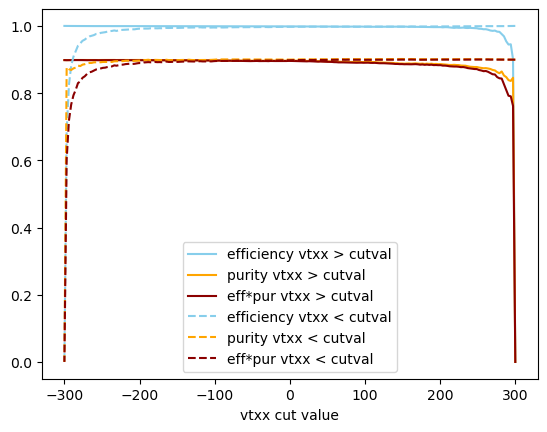

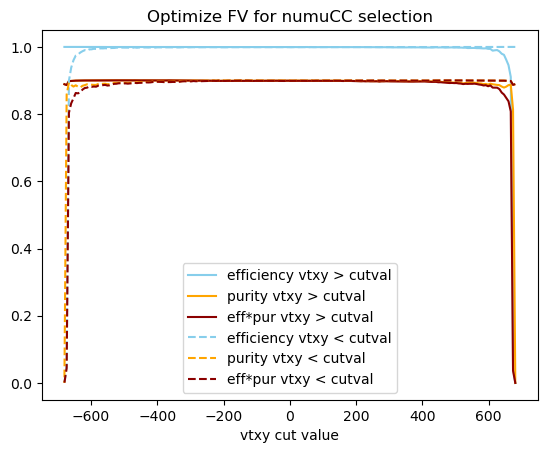

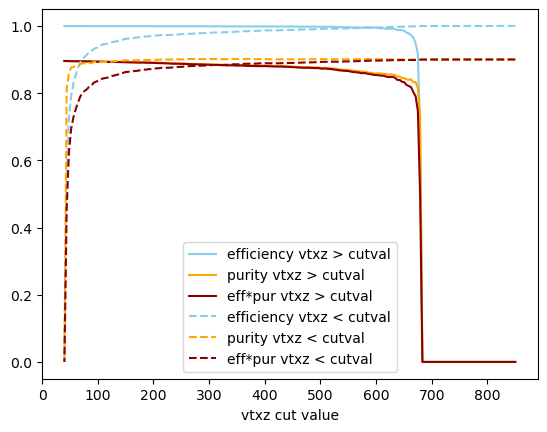

In [15]:
true_cuts = (dfnumucc["true_nupdg"] == 14) & dfnumucc["true_iscc"]

fvopt_lb(dfnumucc, "x", [-300, 300], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnumucc, "x", [300, -300], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxx cut value")
plt.legend()
plt.show()
plt.title("Optimize FV for numuCC selection")


fvopt_lb(dfnumucc, "y", [-680, 680], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnumucc, "y", [680, -680], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxy cut value")
plt.legend()
plt.show()

fvopt_lb(dfnumucc, "z", [40, 850], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnumucc, "z", [850, 40], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxz cut value")
plt.legend()
plt.show()

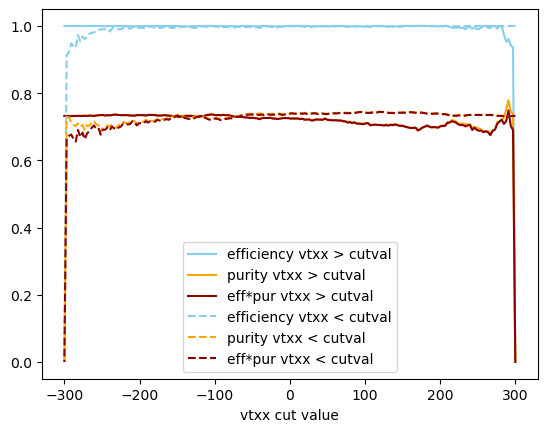

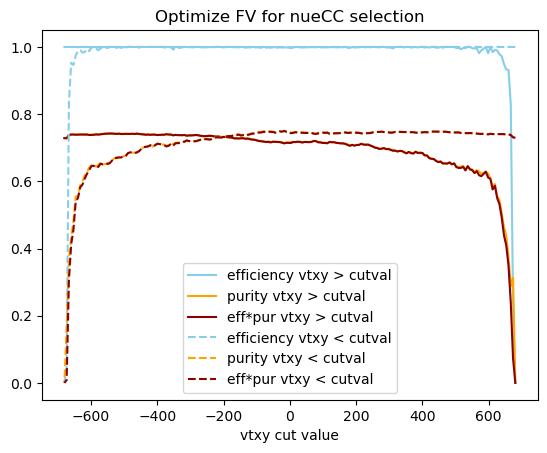

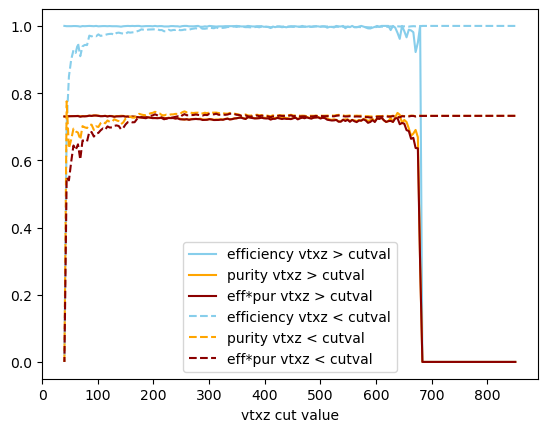

In [16]:
true_cuts = (dfnuecc["true_nupdg"] == 12) & dfnuecc["true_iscc"]

fvopt_lb(dfnuecc, "x", [-300, 300], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnuecc, "x", [300, -300], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxx cut value")
plt.legend()
plt.show()
plt.title("Optimize FV for nueCC selection")


fvopt_lb(dfnuecc, "y", [-680, 680], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnuecc, "y", [680, -680], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxy cut value")
plt.legend()
plt.show()

fvopt_lb(dfnuecc, "z", [40, 850], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnuecc, "z", [850, 40], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxz cut value")
plt.legend()
plt.show()

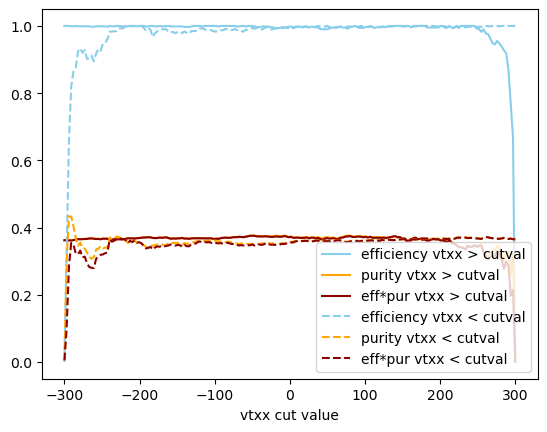

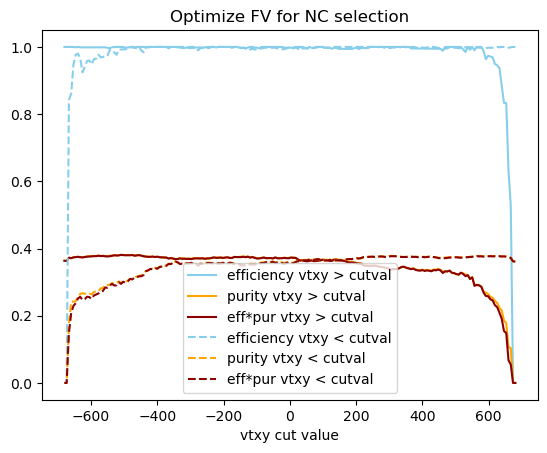

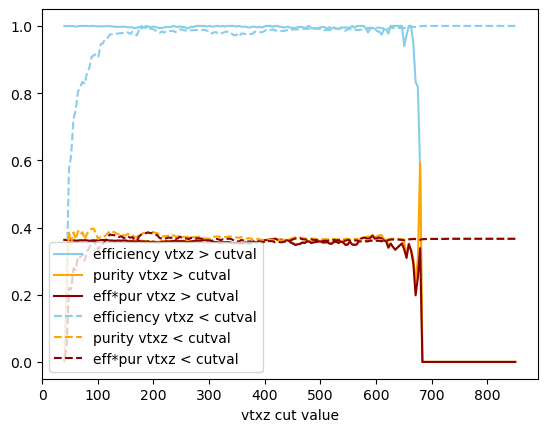

In [17]:
true_cuts = ~dfnc["true_iscc"]

fvopt_lb(dfnc, "x", [-300, 300], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnc, "x", [300, -300], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxx cut value")
plt.legend()
plt.show()
plt.title("Optimize FV for NC selection")


fvopt_lb(dfnc, "y", [-680, 680], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnc, "y", [680, -680], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxy cut value")
plt.legend()
plt.show()

fvopt_lb(dfnc, "z", [40, 850], true_cuts, ["skyblue", "orange", "darkred"], "solid")
fvopt_ub(dfnc, "z", [850, 40], true_cuts, ["skyblue", "orange", "darkred"], "dashed")
plt.xlabel(f"vtxz cut value")
plt.legend()
plt.show()

Looks like the CVN training FV is as good as we can do!

# Reconstruction Smearing

Check the smearing on some important reconstructed quantities

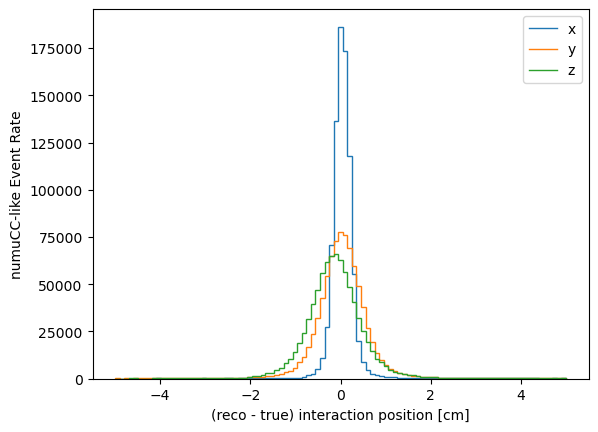

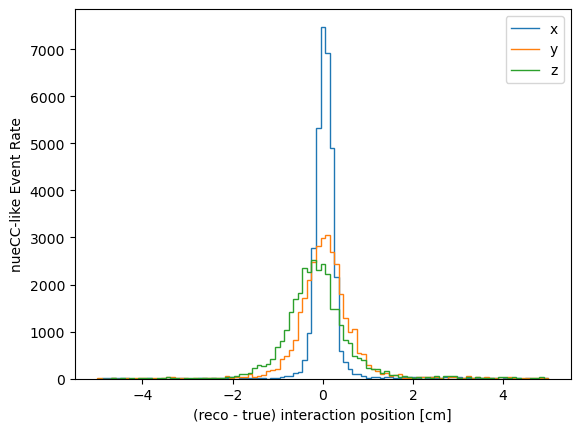

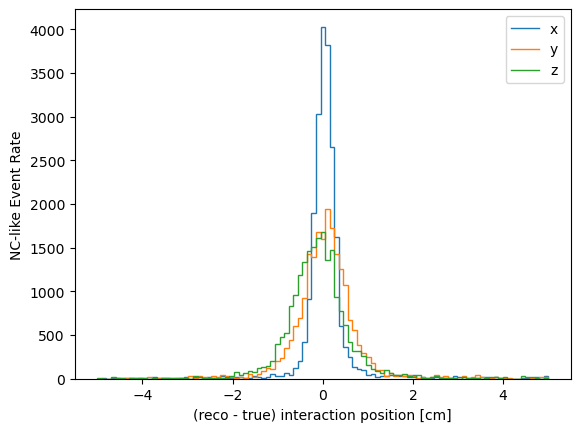

In [18]:
plt.stairs(*hist1d(dfnumucc["vtxx"] - dfnumucc["true_vtxx"], np.linspace(-5,5,100), dfnumucc["oscprob"]), label="x")
plt.stairs(*hist1d(dfnumucc["vtxy"] - dfnumucc["true_vtxy"], np.linspace(-5,5,100), dfnumucc["oscprob"]), label="y")
plt.stairs(*hist1d(dfnumucc["vtxz"] - dfnumucc["true_vtxz"], np.linspace(-5,5,100), dfnumucc["oscprob"]), label="z")

plt.xlabel("(reco - true) interaction position [cm]")
plt.ylabel("numuCC-like Event Rate")
plt.legend()
plt.show()

plt.stairs(*hist1d(dfnuecc["vtxx"] - dfnuecc["true_vtxx"], np.linspace(-5,5,100), dfnuecc["oscprob"]), label="x")
plt.stairs(*hist1d(dfnuecc["vtxy"] - dfnuecc["true_vtxy"], np.linspace(-5,5,100), dfnuecc["oscprob"]), label="y")
plt.stairs(*hist1d(dfnuecc["vtxz"] - dfnuecc["true_vtxz"], np.linspace(-5,5,100), dfnuecc["oscprob"]), label="z")

plt.xlabel("(reco - true) interaction position [cm]")
plt.ylabel("nueCC-like Event Rate")
plt.legend()
plt.show()

plt.stairs(*hist1d(dfnc["vtxx"] - dfnc["true_vtxx"], np.linspace(-5,5,100), dfnc["oscprob"]), label="x")
plt.stairs(*hist1d(dfnc["vtxy"] - dfnc["true_vtxy"], np.linspace(-5,5,100), dfnc["oscprob"]), label="y")
plt.stairs(*hist1d(dfnc["vtxz"] - dfnc["true_vtxz"], np.linspace(-5,5,100), dfnc["oscprob"]), label="z")

plt.xlabel("(reco - true) interaction position [cm]")
plt.ylabel("NC-like Event Rate")
plt.legend()
plt.show()

Also worth looking at the reconstructed energy smearing

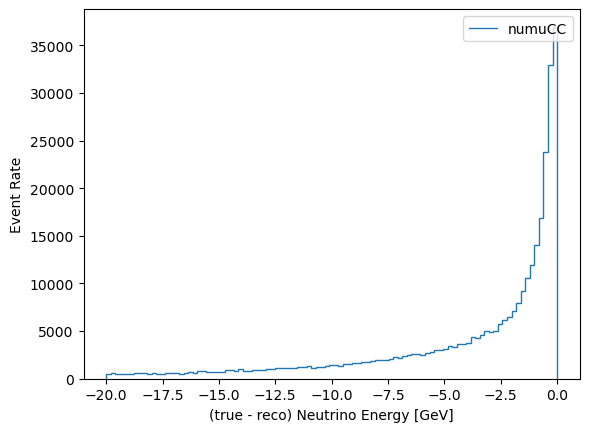

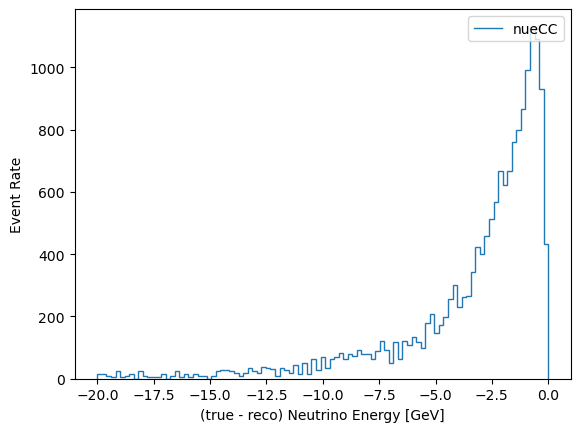

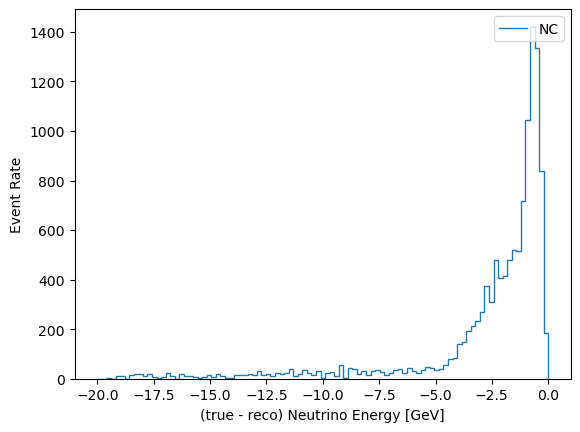

In [22]:
plt.stairs(*hist1d(dfnumucc["enu_lep_calo"] - dfnumucc["true_enu_GeV"], np.linspace(-20,0,100), dfnumucc["oscprob"]), label="numuCC")
plt.xlabel("(true - reco) Neutrino Energy [GeV]")
plt.ylabel("Event Rate")
plt.legend()
plt.show()

plt.stairs(*hist1d(dfnuecc["enu_lep_calo"] - dfnuecc["true_enu_GeV"], np.linspace(-20,0,100), dfnuecc["oscprob"]), label="nueCC")
plt.xlabel("(true - reco) Neutrino Energy [GeV]")
plt.ylabel("Event Rate")
plt.legend()
plt.show()

plt.stairs(*hist1d(dfnc["enu_calo"] - dfnc["true_enu_GeV"], np.linspace(-20,0,100), dfnc["oscprob"]), label="NC")
plt.xlabel("(true - reco) Neutrino Energy [GeV]")
plt.ylabel("Event Rate")
plt.legend()
plt.show()

The very long tail deserves a bit more investigation, can break down the missed energy as a function of true energy.

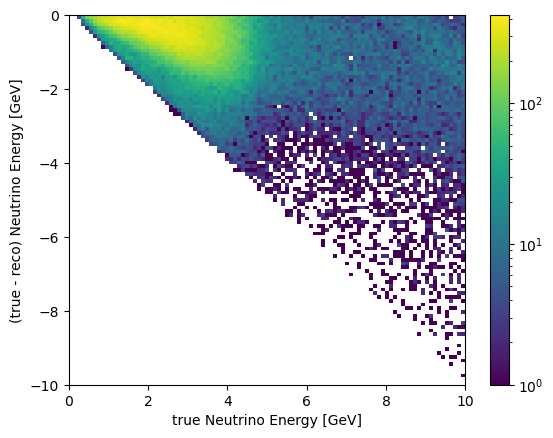

In [25]:
import matplotlib.colors as colors

def drawhist2d(datax, datay, bins, *, logz=False, **kwargs):
    counts, xbins, ybins = np.histogram2d(datax, datay, bins=bins)

    if logz:
        pcm = plt.pcolormesh(xbins, ybins, counts.T, 
                             norm=colors.LogNorm(vmin=1, vmax=counts.max()))
    else:
        pcm = plt.pcolormesh(xbins, ybins, counts.T)
    
    plt.gcf().colorbar(pcm, ax=plt.gca())

drawhist2d(dfnumucc["true_enu_GeV"], dfnumucc["enu_lep_calo"] - dfnumucc["true_enu_GeV"], 
           (np.linspace(0,10,100), np.linspace(-10,0,100)), logz=True)
plt.xlabel("true Neutrino Energy [GeV]")
plt.ylabel("(true - reco) Neutrino Energy [GeV]")
plt.show()